# Quick and Dirty attempt to train a model

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import time

verbose = False  # should print out extra details?

%matplotlib inline

In [2]:
print(f'FastAi: {fastai.__version__}')
print(f'Torch: {torch.__version__}')

FastAi: 1.0.52
Torch: 1.1.0


In [3]:
bs = 32  ## for out of memory
num_workers = 4  # set to 0 or 1 when using windows or kaggle
image_size = 224

In [4]:
data_fp = Path('data')
data_train = data_fp/'train'
sub_fp = Path('submission') 

In [5]:
# look at folder tree
!tree -d {data_fp}

data
├── models
├── test
├── test_crop_224
├── train
└── train_playground
    └── models

6 directories


# Looking at the data

In [6]:
labels = pd.read_csv(data_fp/'train.csv')
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


## Split data into training and validation set
Because the data is extremely unbalance where it contains classes with only one sample, we cannot use a random sampling method.   
Fastai will get an error when there is a class in the validation set and not in training set. [link](https://github.com/fastai/fastai/issues/1273)

In addition, we cannot use StratifiedShuffleSplit because the minimum number of groups for any class cannot be less than 2.   
Therefore, we will need to duplicate images for this to work. Instead, we will manually create a train and validation split. 

In [7]:
# ## Save code just in case for future use
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# ## split is decided by the Id column
# for train_index, val_index in sss.split(labels.index.values, labels.Id):
#     train_idx, val_idx = train_index, val_index  

In [8]:
class_counts = labels.Id.value_counts(sort=True, ascending=True)
print(f'The number of images: {class_counts.sum():,}')
print('{}'.format('='*20))
print(f'Number of classes with only one image: {sum(class_counts == 1):,}')
print(f'Percentage of classes with one image: {sum(class_counts == 1)/len(labels.Id.unique()):.0%}')
print('{}'.format('='*20))
print(f'Number of new_whate image: {class_counts["new_whale"].sum():,}')
print(f'Percentage of images are new_whale: {class_counts["new_whale"]/class_counts.sum()*100:0.0f}%')

The number of images: 25,361
Number of classes with only one image: 2,073
Percentage of classes with one image: 41%
Number of new_whate image: 9,664
Percentage of images are new_whale: 38%


In [9]:
class_counts[::-1][:5]  # top five most common class

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

### Stratified Split
Split the data such that classes with only 1 sample will go into training set and classes with 2+ will split randomly with ~20% into validation set. 

In [10]:
start_time = time.time()
## stratify sampling that can handle 
train_idx, val_idx = pd.Series(), pd.Series()
for name, group in labels.reset_index()[['index', 'Id']].groupby(['Id']):
    ## if a class only have 1 sample, just return that one
    if group.shape[0] == 1:
        train, val = group['index'], []
    ## split each group randomly and obtain their index
    else:
        train, val = train_test_split(group['index'], test_size=0.2, random_state=None)
    train_idx = train_idx.append(train)
    val_idx = val_idx.append(val)
    
print(f'It took {int(time.time() - start_time)} seconds')

It took 2 seconds


In [11]:
train_idx.head()

1357      1357
20281    20281
2814      2814
15585    15585
19290    19290
dtype: int64

In [12]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


The training/validation split is off from the 80/20 split because classes with a small amount of images are harder to split with that ratio.  
For instance, classes with 2 images will do a 50/50 split such that atleast one is in training and validation. 

## Create ImageDataBunch

In [13]:
tfms = get_transforms(flip_vert=False, max_zoom=1)  ## remove vertical and zooming
if verbose: tfms  ## list of transformations done to the images. tfms[0] is for training and tfms[1] is for validation

In [14]:
src = (ImageList.from_df(path=data_fp, df=labels, cols='Image', folder='train')
                     # images' filepath are in a dataframe with column name 'Image'
                    .split_by_idx(val_idx)
                    # validations are not random and determined by the row indices
                    .label_from_df(cols='Id')
                    # classes for the images are in a dataframe with column name 'Id'
                    .add_test_folder())
                    # images to be use for inferences to the kaggle competition
if verbose: print(f'Type({type(src)})')
if verbose : print(src)  # show a summary of the datasets

In [15]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.transform(tfms, 
                          size=size,
                          resize_method=ResizeMethod.PAD,
                          padding_mode=padding_mode)
                .databunch(bs=bs, num_workers=num_workers)
                # creates a dataloader
                .normalize(imagenet_stats))
                # normalize the whale images with imagenet's mean and std because we are using a pretrained model

In [16]:
data = get_data(image_size, bs, 'border')

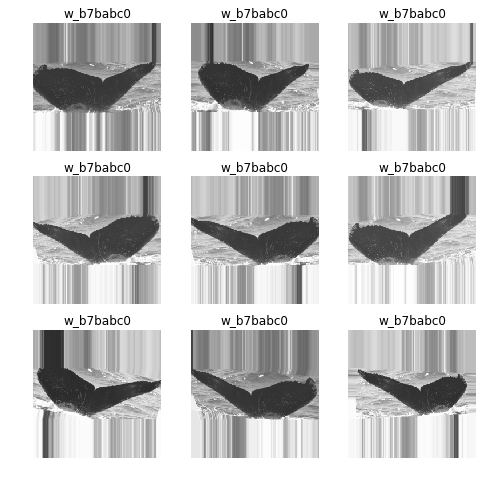

In [17]:
# Display examples of the transformation on a single image
def _plot(i,j,ax):
    x,y = data.train_ds[idx]
    x.show(ax,y=y)

idx = np.random.randint(len(data.train_ds))
plot_multi(_plot, 3, 3, figsize=(8,8))  ## show how the image is being transformed

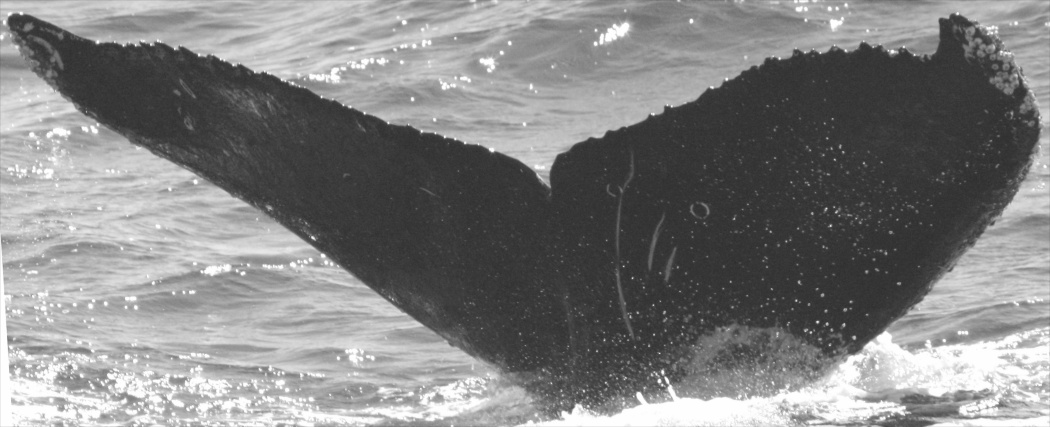

In [18]:
open_image(data.train_ds.items[idx]) # orginal image

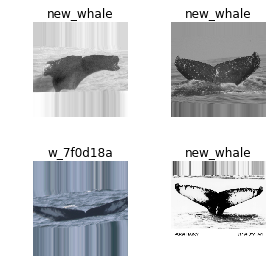

In [19]:
data.show_batch(rows=2, figsize=(4,4))  # this keeps crashing my computer

## Training

In [20]:
def mapr(input: torch.Tensor, targs: torch.LongTensor, mapn: int):
    "Compute the mean average precision"
    n = targs.shape[0]  # number for samples
    input = input.argsort(dim=-1, descending=True)[:,:mapn]
    targs = targs.view(n, -1)
    return ((input == targs).float()/torch.arange(1,mapn+1, device=input.device).float()).sum(dim=-1).mean()

map5 = partial(mapr, mapn=5)

In [73]:
# pre-trained = true means to use pre-trained weights and to freeze the body weights and only train the head
# the head will be replaced with: an AdaptiveConcatPool2d, Flatten, and blocks of [BatchNorm1d, Dropout, Linear, RelU]
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


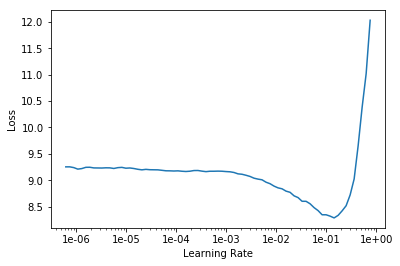

In [74]:
learn.lr_find()
learn.recorder.plot()

## Testing Learning Rate Range

In [104]:
lr_range = np.round(np.linspace(1e-4, 2e-2, num=5), 4); lr_range

array([0.0001, 0.0051, 0.01  , 0.015 , 0.02  ])

===========Learning Rate: 0.0001===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,8.351116,8.149405,0.143522,0.149059,03:36
1,6.940717,7.062496,0.263953,0.269103,03:35
2,6.094266,6.461622,0.294186,0.303552,03:35
3,5.669845,6.216297,0.301993,0.314817,03:35
4,5.602509,6.164108,0.306312,0.318904,03:36


===========Learning Rate: 0.0051===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.950944,6.249081,0.318937,0.328948,03:35
1,5.587264,5.865623,0.321595,0.337115,03:35
2,5.425879,5.623056,0.329236,0.349338,03:35
3,5.006354,5.413658,0.335548,0.364031,03:35
4,4.817438,5.363072,0.341860,0.369477,03:35


===========Learning Rate: 0.01===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,6.219775,6.536797,0.318605,0.325484,03:36
1,5.798892,6.050085,0.320930,0.327597,03:35
2,5.599667,6.243247,0.318439,0.327339,03:35
3,5.224854,6.687220,0.322425,0.335720,03:34
4,5.156887,6.301398,0.323090,0.339211,03:35


===========Learning Rate: 0.015===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,6.100262,6.275661,0.320598,0.325188,03:35
1,5.846046,12.544078,0.300664,0.305941,03:35
2,5.857293,35.989212,0.311296,0.317658,03:35
3,5.487043,16.575430,0.316944,0.326201,03:34
4,5.304547,21.816620,0.316944,0.327381,03:34


===========Learning Rate: 0.02===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,6.208154,6.665071,0.317774,0.322165,03:35
1,6.202841,17.688307,0.294850,0.296899,03:34
2,5.986382,639.264893,0.308306,0.310061,03:34
3,5.527183,779.622925,0.305149,0.311005,03:34
4,5.362954,503.325043,0.310631,0.319189,03:34


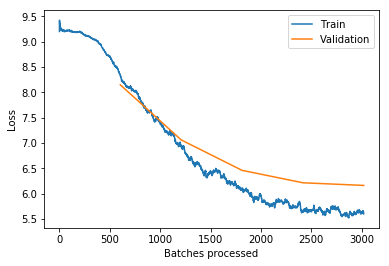

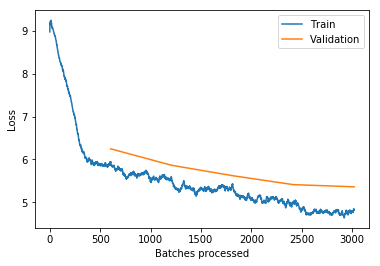

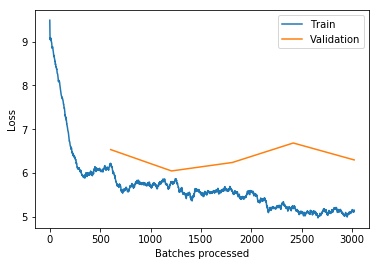

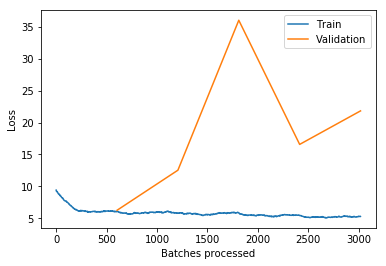

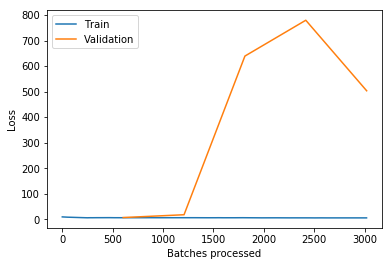

In [105]:
for lr in lr_range:
    print(f'===========Learning Rate: {lr}===========')
    learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)
    learn.fit_one_cycle(5, lr)
    learn.recorder.plot_losses()

### Fine Tuning head

**Notes on learning rate** 
* lr = 2e-2                  
    * train every layer with the same lr
* r = slice(2e-2)           
    * train the head (final layers) with 2e-2 and the body with lr/3. divide by 3 b/c of batchnorm..
* lr = slice(1e-5, 2e-2)     
    * train the head with 2e-2, the first layers will get 1e-5 and the in between will get multiplical-equally spaces values between min/max

by default there are three layer groups. The body is split in half and th head is another. 

In [106]:
# how discriminative learning rate is created
lr = slice(1e-3, 8e-2)
even_mults(lr.start, lr.stop, 3)

array([0.001   , 0.008944, 0.08    ])

In [111]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)

In [112]:
learn.fit_one_cycle(5, 0.0051)

epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.834754,6.273888,0.312957,0.327799,03:35
1,5.596337,5.915156,0.323920,0.337627,03:35
2,5.319838,5.634891,0.331894,0.353746,03:35
3,5.018244,5.390936,0.345183,0.372107,03:36
4,4.699206,5.326200,0.348173,0.376717,03:35


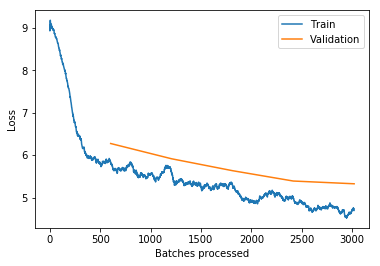

In [113]:
learn.recorder.plot_losses()

0.00020400000000000003 0.0051


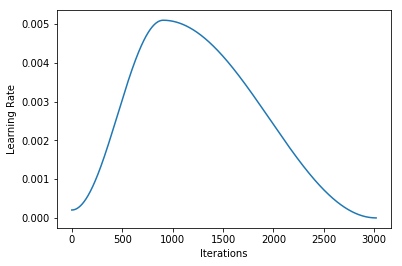

In [115]:
print(learn.recorder.lrs[0], max(learn.recorder.lrs))
learn.recorder.plot_lr()

In [ ]:
## checkpoint! save model

### Unfreeze and train on whole model with discriminative learning rate

In [116]:
learn.unfreeze()  # train whole model now

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


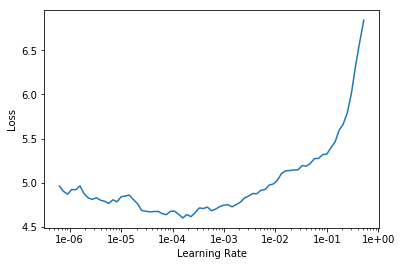

In [117]:
learn.lr_find()
learn.recorder.plot()

In [118]:
lr = 1e-4

In [119]:
learn.fit_one_cycle(10, slice(lr, lr/5), pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,mapr,time
0,4.705665,5.348762,0.346678,0.375900,04:40
1,4.766650,5.360085,0.344020,0.371647,04:39
2,4.649400,5.371540,0.343854,0.372464,04:40
3,4.610495,5.313442,0.346512,0.374053,04:40
4,4.616045,5.270838,0.353322,0.381735,04:40
5,4.676273,5.219815,0.356977,0.387179,04:39
6,4.563288,5.175910,0.360465,0.390573,04:39
7,4.505429,5.157383,0.365449,0.394471,04:40
8,4.342365,5.117607,0.367608,0.396442,04:40
9,4.404156,5.143469,0.365781,0.395567,04:39


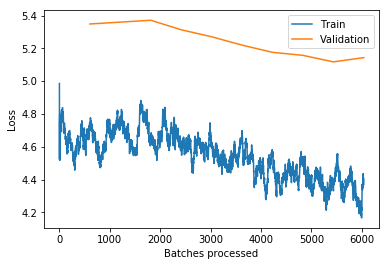

In [120]:
learn.recorder.plot_losses()

8e-07 1.9999999999999998e-05


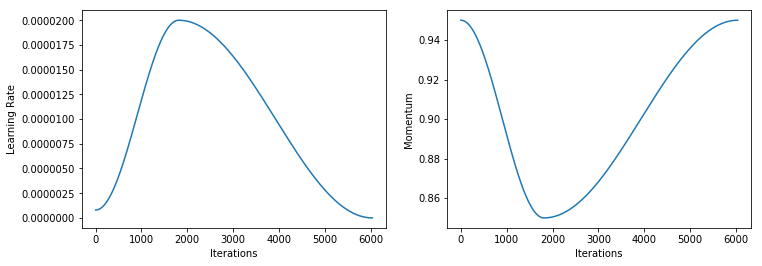

In [124]:
print(learn.recorder.lrs[0], max(learn.recorder.lrs))
learn.recorder.plot_lr(show_moms=True)

In [122]:
learn.save??

Signature:
learn.save(
    file: Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO] = None,
    return_path: bool = False,
    with_opt: bool = True,
)
Source:   
    def save(self, file:PathLikeOrBinaryStream=None, return_path:bool=False, with_opt:bool=True):
        "Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)"
        if is_pathlike(file): self._test_writeable_path()
        if rank_distrib(): return # don't save if slave proc
        target = self.path/self.model_dir/f'{file}.pth' if is_pathlike(file) else file
        if not hasattr(self, 'opt'): with_opt=False
        if not with_opt: state = get_model(self.model).state_dict()
        else: state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
        torch.save(state, target)
        if return_path: return target
File:      ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py
Type:      method


In [127]:
learn.save('first_attempt-stage-2')

## Get predictions. 

Try TTA

In [128]:
pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [129]:
pred.shape

torch.Size([7960, 5005])

In [130]:
def create_submission(preds, data, path, name, mapn=5):
    preds_sort = preds.argsort(dim=-1, descending=True)[:,:mapn]
    cls_np = np.asarray(data.classes)
    (pd.DataFrame({"Image": [fn.name for fn in data.test_ds.items],
                  "Id": [" ".join(cls_np[idx]) for idx in preds_sort.numpy()]})
        .to_csv(path/name, index=False))

In [131]:
create_submission(pred, learn.data, sub_fp,'testing2.csv')

In [132]:
pd.read_csv(sub_fp/'testing2.csv').head()

,Image,Id
0,a348f5ac5.jpg,new_whale w_9b5109b w_4bf625b w_0369a5c w_cd4cb49
1,1b7ee8ac5.jpg,new_whale w_a113b33 w_bfcad53 w_9c506f6 w_234713b
2,a11d5558d.jpg,new_whale w_16df050 w_4bf625b w_9b5109b w_b3197c6
3,51b4747d8.jpg,new_whale w_d405854 w_2365d55 w_5773c71 w_ef83760
4,033304f3f.jpg,new_whale w_f765256 w_659bdb8 w_0135f5f w_da011a1


In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/sub_test.csv" -m "sub_test"